In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import pandas as pd
# import sagemaker
# from sagemaker.pytorch import PyTorch

from src import fetch_bucketed_from_bitmex, preprocess, train, evaluate

input_dir = 'cache_input'
model_dir = 'cache_model'
output_dir = 'cache_output'
# role = sagemaker.get_execution_role()
# sagemaker_session = sagemaker.Session()
# bucket = sagemaker_session.default_bucket()

# Crawling the Dataset

In [2]:
df = fetch_bucketed_from_bitmex('XBTZ19', '1m')

.


# Feature Engineering

In [3]:
preprocess(df, input_dir)

# Training

### Benchmark: Linear Model

In [2]:
train(
    input_dir=input_dir,
    output_dir=output_dir,
    model_dir=model_dir,
    checkpoint_path=None,
    # checkpoint_path='cache_output/checkpoint.pth',
    model_class="linear",
)

Using device cpu.
| epoch | trai loss | vali loss | time/s |
| ----: | --------- | --------- | -----: |
|     0 | 1.899e-01 | 1.293e+00 |      0 |
|     1 | 1.030e-01 | 4.097e-01 |      0 |
|     2 | 6.349e-02 | 2.174e-01 |      0 |
|     3 | 2.706e-02 | 1.095e-01 |      0 |
|     4 | 2.910e-02 | 7.595e-02 |      0 |
|     5 | 1.630e-02 | 5.908e-02 |      0 |
|     6 | 1.259e-02 | 5.196e-02 |      0 |
|     7 | 1.054e-02 | 4.787e-02 |      0 |
|     8 | 9.013e-03 | 4.845e-02 |      0 |
|     9 | 8.449e-03 | 4.837e-02 |      0 |
|    10 | 8.274e-03 | 4.820e-02 |      0 |
|    11 | 8.131e-03 | 4.797e-02 |      0 |
|    12 | 7.849e-03 | 4.791e-02 |      0 |
|    13 | 7.823e-03 | 4.786e-02 |      0 |
|    14 | 7.804e-03 | 4.781e-02 |      0 |
|    15 | 7.787e-03 | 4.777e-02 |      0 |


### Solution: LSTM Model

In [4]:
inputs = sagemaker_session.upload_data(
    path=input_dir, bucket=bucket, key_prefix="lstm-trader"
)

In [5]:
estimator = PyTorch(
    source_dir="lstm_trader",
    entry_point="trainer.py",
    hyperparameters={
        "seq-len": 128,
        "hidden-dim": 64,
        "n-epochs": 16,
        "batch-size": 1024,
    },
    framework_version="1.2.0",
    role=role,
    sagemaker_session=sagemaker_session,
    train_instance_count=1,
    train_instance_type="ml.p2.xlarge",
)

estimator.fit({"data_dir": inputs})

2019-12-28 09:50:50 Starting - Starting the training job...
2019-12-28 09:50:52 Starting - Launching requested ML instances.........
2019-12-28 09:52:23 Starting - Preparing the instances for training......
2019-12-28 09:53:33 Downloading - Downloading input data......
2019-12-28 09:54:33 Training - Downloading the training image...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-12-28 09:56:38,458 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-12-28 09:56:38,482 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.

2019-12-28 09:56:37 Training - Training image download completed. Training in progress.2019-12-28 09:56:44,696 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-12-28 09:56:44,962 sagemaker-containers INFO     Module trainer does not provide a setup.py. 
Generating setup.py
2019-12-28 09:56

In [6]:
sagemaker_session.download_data(
    path=output_dir,
    bucket=bucket,
    key_prefix=estimator.latest_training_job.name + "/output/output.tar.gz",
)
sagemaker_session.download_data(
    path=model_dir,
    bucket=bucket,
    key_prefix=estimator.latest_training_job.name + "/output/model.tar.gz",
)
!tar xvf cache_output/output.tar.gz --directory=cache_output
!tar xvf cache_model/model.tar.gz --directory=cache_model

# Evaluation

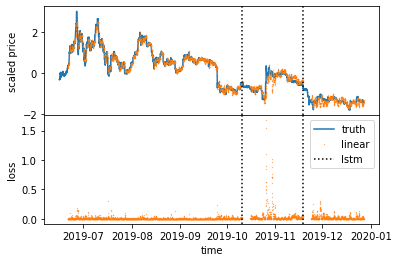

In [3]:
evaluate(input_dir, model_dir, seq_len=128)